In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

RANDOM_STATE = 42
BATCH_SIZE = 32
NUM_WORKERS = 4
IMG_SIZE = (224, 224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Data augmentation

# ImageNet Normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    # transforms.CenterCrop(224),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [3]:
# Load the datasets

train_dir = "./data/train"
test_dir = "./data/val"

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=test_transform)

print(f"Train data:\n{train_data}")
print(f"Test data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=warn)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 153
    Root location: ./data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )


In [4]:
class_names = train_data.classes
class_names

['ants', 'bees']

In [5]:
# TODO: change to NWHC
train_data[0][0].shape

torch.Size([3, 224, 224])

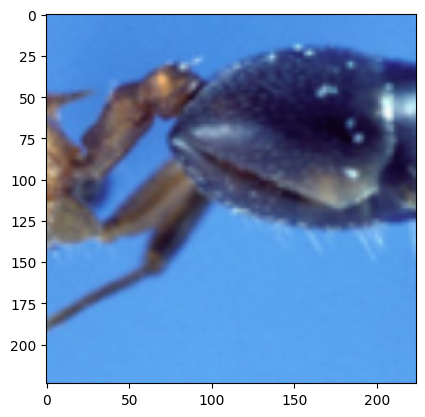

In [6]:
# display one image
sample_img, sample_label = train_data[0]

def display(img):
    # convert to NWHC since that's what matplotlib expects
    img = img.permute(1, 2, 0).numpy()

    # undo normalization
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    
display(train_data[0][0])

In [7]:
# Create dataloaders

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fbfac38c0a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fbfac38d240>)

In [8]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [9]:
# Load EfficientNet
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights.transforms() # check image transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [11]:
# Freeze all base layers in the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
# Change the last layer
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # binary classifier
                    bias=True)
).to(device)

In [13]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [15]:
# Train one batch for demonstrative purposes

train_loss, train_acc = 0, 0

img_batch, label_batch = next(iter(train_dataloader))

# training
X, y = img_batch.to(device), label_batch.to(device).float()

# Forward pass
y_logits = model(X).squeeze()
y_pred = torch.round(torch.sigmoid(y_logits))

# Calculate and accumulate loss
loss = loss_fn(y_logits, y) 
acc = accuracy_fn(y_true=y, y_pred=y_pred)

train_loss += loss.item()
train_acc += acc

# Zero out gradients
optimizer.zero_grad()

# Backpropogate
loss.backward()

# Update weights
optimizer.step()
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{y_logits}\n")
print(f"Output prediction probabilities:\n{y_pred}\n")
print(f"Actual label:\n{y}")

Output logits:
tensor([ 0.0880,  0.1650,  0.0548, -0.4124, -0.4068,  0.2066, -0.0091, -0.1020,
         0.0605, -0.0824, -0.4750,  0.0925,  0.3181,  0.0673, -0.2602, -0.2275,
         0.0221, -0.2624,  0.0432,  0.1694, -0.0434, -0.1916,  0.1856,  0.0930,
         0.0154, -0.5369,  0.3829, -0.1379, -0.1040, -0.0256, -0.3257, -0.2979],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

Output prediction probabilities:
tensor([1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<RoundBackward0>)

Actual label:
tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       device='cuda:0')


In [16]:
### Test one batch for demonstrative purposes
model.eval()

test_loss, test_acc = 0, 0

with torch.inference_mode():
    # 1. Forward pass
    test_logits = model(X).squeeze() 
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    # 2. Caculate loss/accuracy and accumulate
    loss = loss_fn(test_logits, y)
    acc = accuracy_fn(y_true=y, y_pred=test_pred)
    
    test_loss += loss.item()
    test_acc += acc
    
test_loss, test_acc

(0.6742544174194336, 65.625)

In [17]:
# Train test loop
epochs = 10

for epoch in range(epochs):
    
    # Training
    model.train()
    
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device).float()

        # Forward pass
        y_logits = model(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Calculate loss and accuracy
        loss = loss_fn(y_logits, y) 
        acc = accuracy_fn(y_true=y, y_pred=y_pred)

        # Accumulate
        train_loss += loss.item()
        train_acc += acc

        # Zero out gradients
        optimizer.zero_grad()

        # Backpropogate
        loss.backward()

        # Update weights
        optimizer.step()
        

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    
    # Testing
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(test_dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device).float()

            # 1. Forward pass
            test_logits = model(X).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))

            # Calculate loss and accuracy
            loss = loss_fn(test_logits, y)
            acc = accuracy_fn(y_true=y, y_pred=test_pred)

            # Accumulate
            test_loss += loss.item()
            test_acc += acc

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    
    
    # Display train/test data for each epoch
    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

Epoch: 1 | train_loss: 0.6672 | train_acc: 61.2500 | test_loss: 0.5454 | test_acc: 88.1250
Epoch: 2 | train_loss: 0.5761 | train_acc: 75.1562 | test_loss: 0.4603 | test_acc: 90.6250
Epoch: 3 | train_loss: 0.5209 | train_acc: 84.0625 | test_loss: 0.4057 | test_acc: 91.2500
Epoch: 4 | train_loss: 0.4872 | train_acc: 84.7656 | test_loss: 0.3616 | test_acc: 93.1250
Epoch: 5 | train_loss: 0.4601 | train_acc: 88.9844 | test_loss: 0.3317 | test_acc: 94.2000
Epoch: 6 | train_loss: 0.4190 | train_acc: 88.4375 | test_loss: 0.3036 | test_acc: 94.2000
Epoch: 7 | train_loss: 0.3937 | train_acc: 86.6406 | test_loss: 0.2809 | test_acc: 94.8250
Epoch: 8 | train_loss: 0.3647 | train_acc: 87.0312 | test_loss: 0.2610 | test_acc: 94.2000
Epoch: 9 | train_loss: 0.3590 | train_acc: 86.1719 | test_loss: 0.2472 | test_acc: 94.8250
Epoch: 10 | train_loss: 0.3527 | train_acc: 89.4531 | test_loss: 0.2383 | test_acc: 94.2000
